In [154]:
# import libraries

import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import PowerNorm, LinearSegmentedColormap
import matplotlib.patheffects as path_effects
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# read in data

data = pd.read_csv('../../local_data/TestDataPredictionsRF.csv')
data_old = pd.read_csv('../../local_data/TestDataPredictionsRF_old.csv')
print(f'Data the same? {data.equals(data_old)}')
print(data.columns)

# seaborn things

sns.set_context('paper')
sns.set_theme(style="whitegrid", font_scale=1.2)

# and format data (for testing separate by sensor)

y_true = data["class_id"]
y_pred = data["classification"]

Data the same? False
Index(['system:index', 'blue', 'class_id', 'classification', 'fold_rand',
       'green', 'nir', 'red', 'sensor', 'swir1', 'swir2', '.geo'],
      dtype='object')


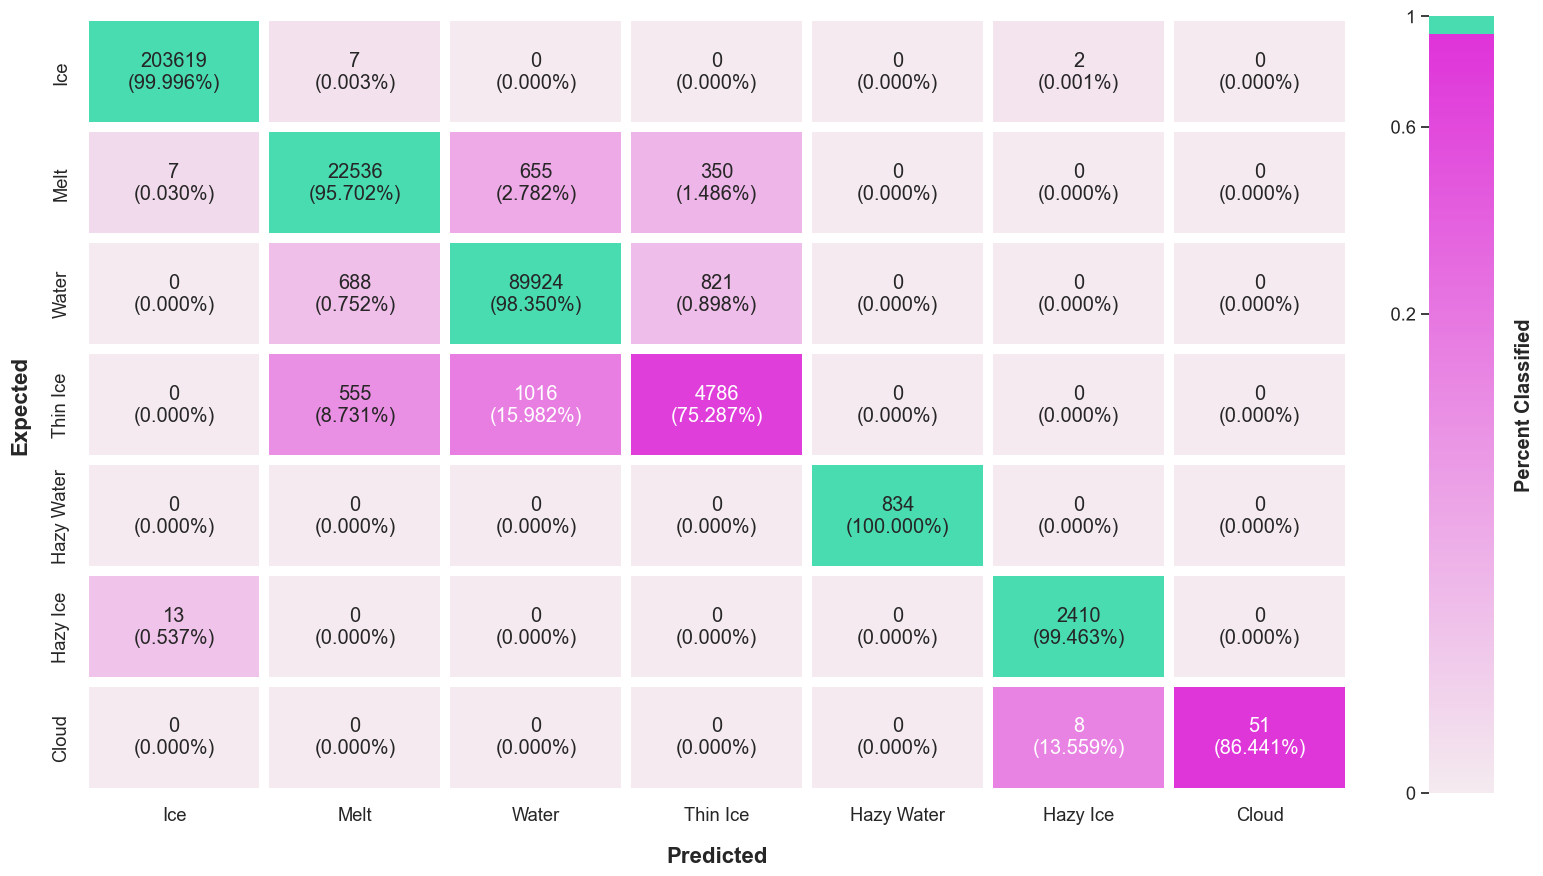

In [155]:
# compute confusion matrix

labels = [1, 2, 3, 4, 5, 6, 7]
cm = confusion_matrix(y_true, y_pred, labels=labels)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# create annotation labels (count + percentage)

annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{cm[i, j]}\n({cm_norm[i, j]:.3%})"

# custom colormap

gamma_val = 0.2
threshold_data = 0.9
threshold_norm = threshold_data ** gamma_val

color_stops = [
    (0.0, "#F4EAEF"),                    # 0%: White
    (threshold_norm - 0.001, "#DF33D9"), # Fades to Pink right up to 94.9%
    (threshold_norm, "#49DCB1"),         # Snaps to Green at exactly 95%
    (1.0, "#49DCB1")                     # Stays Green up to 100%
]
custom_cmap = LinearSegmentedColormap.from_list("PinkGreen", color_stops)

# create figure
class_names = [
    "Ice",
    "Melt",
    "Water",
    "Thin Ice",
    "Hazy Water",
    "Hazy Ice",
    "Cloud"
]

plt.figure(figsize=(17, 9))

ax = sns.heatmap(
    cm_norm,
    annot=annot, # Assuming 'annot' and 'cm_norm' are defined in your environment
    fmt="",
    cmap=custom_cmap,
    norm=PowerNorm(gamma=0.3),
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=6,
    linecolor="white",
    cbar_kws={
        "label": "Percent Classified",
        "aspect": 12,
        "ticks": [0, 0.2, 0.6, 1.0]
    }
)

# Added 'labelpad' to create that teensy bit of extra spacing
ax.set_xlabel("Predicted", fontsize=16, weight="bold", labelpad=16)
ax.set_ylabel("Expected", fontsize=16, weight="bold", labelpad=16)

plt.xticks(rotation=0)
plt.yticks(rotation=90)

# --- Colorbar Customization ---
cbar = ax.collections[0].colorbar

# 1. Update the label strings to match your specified ticks
cbar.set_ticklabels(['0', '0.2', '0.6', '1'])
cbar.ax.yaxis.set_ticks_position('left')

# 3. Add a slight white outline to the inside text so it's readable on both light and dark backgrounds
for label in cbar.ax.get_yticklabels():
    label.set_path_effects([path_effects.withStroke(linewidth=2.5, foreground='white')])

# Make the colorbar title bold and space it out a bit too
cbar.ax.set_ylabel("Percent Classified", weight="bold", labelpad=15)

plt.tight_layout()
plt.show()

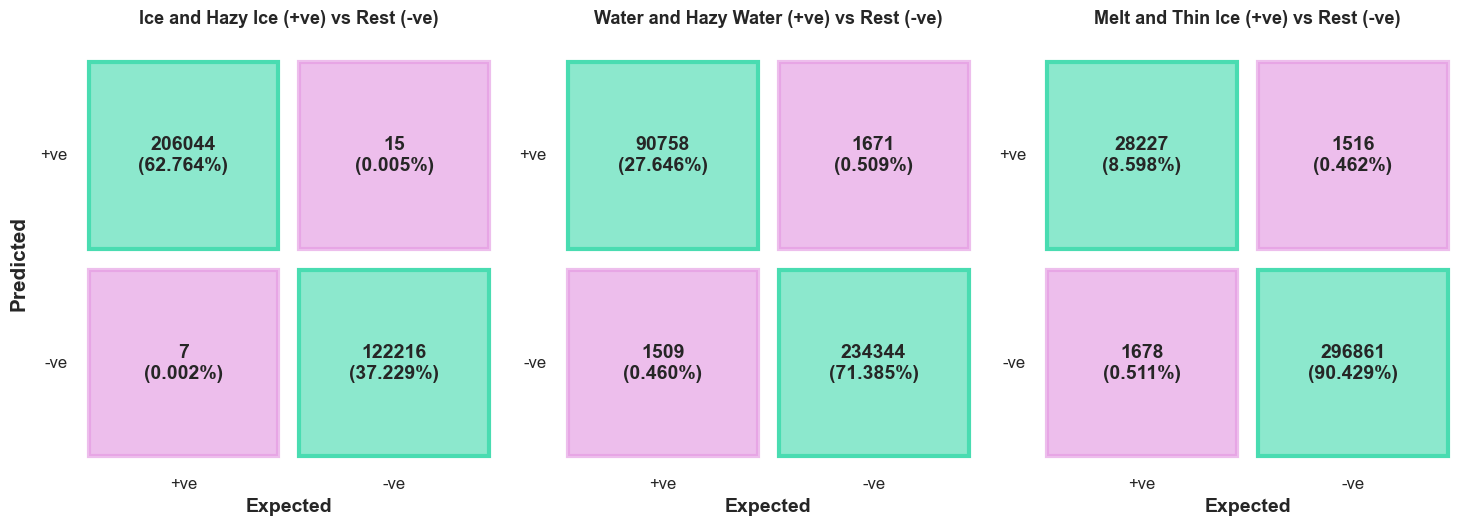

In [157]:
# define classes
groups = {
    "Ice and Hazy Ice (+ve) vs Rest (-ve)": [1, 6],
    "Water and Hazy Water (+ve) vs Rest (-ve)": [3, 5],
    "Melt and Thin Ice (+ve) vs Rest (-ve)": [2, 4]
}

# multiclass confusion matrix
# (Assuming 'data' is already defined in your environment)
y_true = data["class_id"]
y_pred = data["classification"]
labels = sorted(np.unique(np.concatenate((y_true, y_pred))))
cm = confusion_matrix(y_true, y_pred, labels=labels)

# collapse to binary (function)
def collapse_group(cm, positive_classes, labels):
    pos_idx = [labels.index(c) for c in positive_classes]

    # scikit-learn standard: rows = expected, cols = predicted
    TP = cm[np.ix_(pos_idx, pos_idx)].sum()
    
    # Expected positives (rows) that were predicted as something else
    FN = cm[pos_idx, :].sum() - TP
    
    # Expected negatives that were predicted as positive (cols)
    FP = cm[:, pos_idx].sum() - TP
    
    TN = cm.sum() - (TP + FP + FN)

    # Returning formatted for your custom graph: 
    # Row 0 = Predicted +ve (TP, FP)
    # Row 1 = Predicted -ve (FN, TN)
    return np.array([[TP, FP],
                     [FN, TN]])

# create fig
fig, axes = plt.subplots(1, 3, figsize=(15, 5.5))
fig.patch.set_facecolor("white")

for ax, (title, class_group) in zip(axes, groups.items()):
    binary_cm = collapse_group(cm, class_group, labels)

    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor("white")
    
    # Remove default axes borders
    for spine in ax.spines.values():
        spine.set_visible(False)

    # draw squares manually
    colors = [
        ("#49DCB1a1", "#49DCB1"),  # TP
        ("#E499E1a1", "#E499E1a1"),  # FP
        ("#E499E1a1", "#E499E1a1"),  # FN
        ("#49DCB1a1", "#49DCB1")   # TN
    ]

    values = binary_cm.flatten()
    total = binary_cm.sum()
    
    # Calculate percentages (protecting against division by zero)
    percentages = (values / total * 100) if total > 0 else np.zeros_like(values)

    idx = 0
    pad = 0.05  # Spacing between squares

    for i in range(2):
        for j in range(2):
            fill_color, edge_color = colors[idx]

            rect = plt.Rectangle(
                (j + pad, i + pad),
                1 - 2 * pad, 
                1 - 2 * pad,
                facecolor=fill_color,
                edgecolor=edge_color,
                linewidth=3
            )
            ax.add_patch(rect)

            # Added the percentage variable to the text formatting
            ax.text(
                j + 0.5,
                i + 0.5,
                f"{values[idx]}\n({percentages[idx]:.3f}%)",
                ha="center",
                va="center",
                fontsize=14,
                fontweight="bold"
            )

            idx += 1

    ax.set_title(title, fontsize=13, fontweight="bold", pad=20)

    # Expected label and its +ve/-ve indicators
    ax.text(1, 2.15, "Expected", ha="center", va="top", fontsize=14, fontweight="bold")
    ax.text(0.5, 2.05, "+ve", ha="center", va="top", fontsize=12)
    ax.text(1.5, 2.05, "-ve", ha="center", va="top", fontsize=12)

    # Predicted +ve/-ve indicators
    ax.text(-0.05, 0.5, "+ve", va="center", ha="right", fontsize=12)
    ax.text(-0.05, 1.5, "-ve", va="center", ha="right", fontsize=12)

# Add a single master "Predicted" label for the entire figure
fig.supylabel("Predicted", fontsize=15, fontweight="bold")

plt.tight_layout()
plt.show()

In [ ]:
# read in training data

training_data = pd.read_csv('../../local_data/RFTrainingAsset.csv')
sampL = training_data.loc[training_data['sensor'] == 0].sample(10000, random_state=12)
sampS = training_data.loc[training_data['sensor'] == 1].sample(10000, random_state=12)

        class  class_id      blue     green       red       nir     swir1  \
205172  Water         3  0.085199  0.045537  0.024921  0.009953  0.003065   
661074   Melt         2  0.374755  0.298814  0.291783  0.208602  0.012344   
28451   Water         3  0.084591  0.044600  0.023858  0.009523  0.001646   
571319  Water         3  0.143131  0.079700  0.052477  0.024664  0.004920   
814993    Ice         1  0.815080  0.722619  0.774842  0.791280  0.065179   
738257    Ice         1  0.881379  0.803124  0.815957  0.729512  0.050526   
957794    Ice         1  0.785961  0.678118  0.733938  0.766187  0.067703   
399911    Ice         1  0.876091  0.798255  0.810701  0.729221  0.050622   
450700    Ice         1  0.869739  0.792387  0.809605  0.732672  0.052267   
41794   Water         3  0.084414  0.044423  0.023807  0.008940  0.001672   

           swir2                                               .geo  sensor  
205172  0.002001  {"geodesic":false,"type":"Point","coordinates"...       

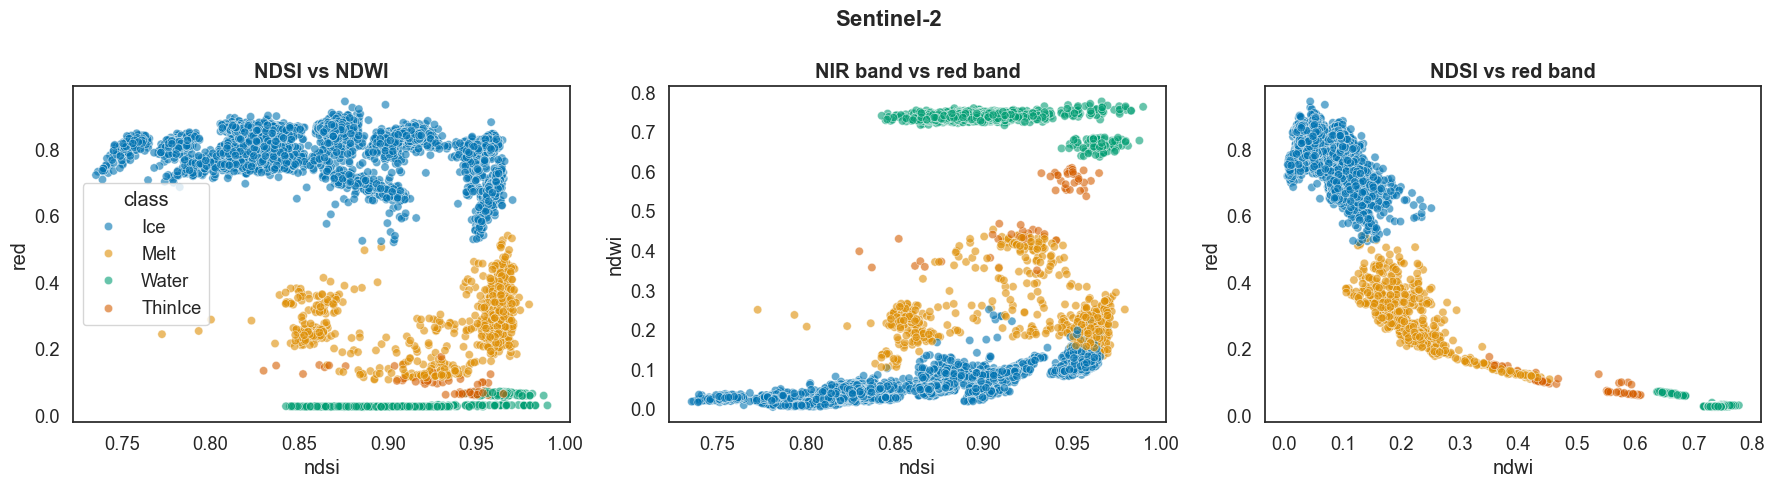

In [162]:
sns.set_style('white')
sampS['ndwi'] = -(sampS['nir'] - sampS['blue']) / (sampS['nir'] + sampS['blue'])
sampS['ndsi'] = -(sampS['swir1'] - sampS['green']) / (sampS['green'] + sampS['swir1'])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# blue vs nir

sns.scatterplot(
    data=sampS, x='ndsi', y='red', 
    hue='class', palette='colorblind', alpha=0.6, 
    ax=axes[0]
)
axes[0].set_title("NDSI vs NDWI", weight="bold")

# nir vs swir1 (hide legend)

sns.scatterplot(
    data=sampS, x='ndsi', y='ndwi', 
    hue='class', palette='colorblind', alpha=0.6, 
    ax=axes[1]
)
axes[1].set_title("NIR band vs red band", weight="bold")
axes[1].get_legend().remove()

# ndsi vs red (hide legend)

sns.scatterplot(
    data=sampS, x='ndwi', y='red', 
    hue='class', palette='colorblind', alpha=0.6, 
    ax=axes[2]
)
axes[2].set_title("NDSI vs red band", weight="bold")
axes[2].get_legend().remove()
plt.suptitle("Sentinel-2", fontsize=16, weight="bold")

# print

plt.tight_layout()
plt.show()

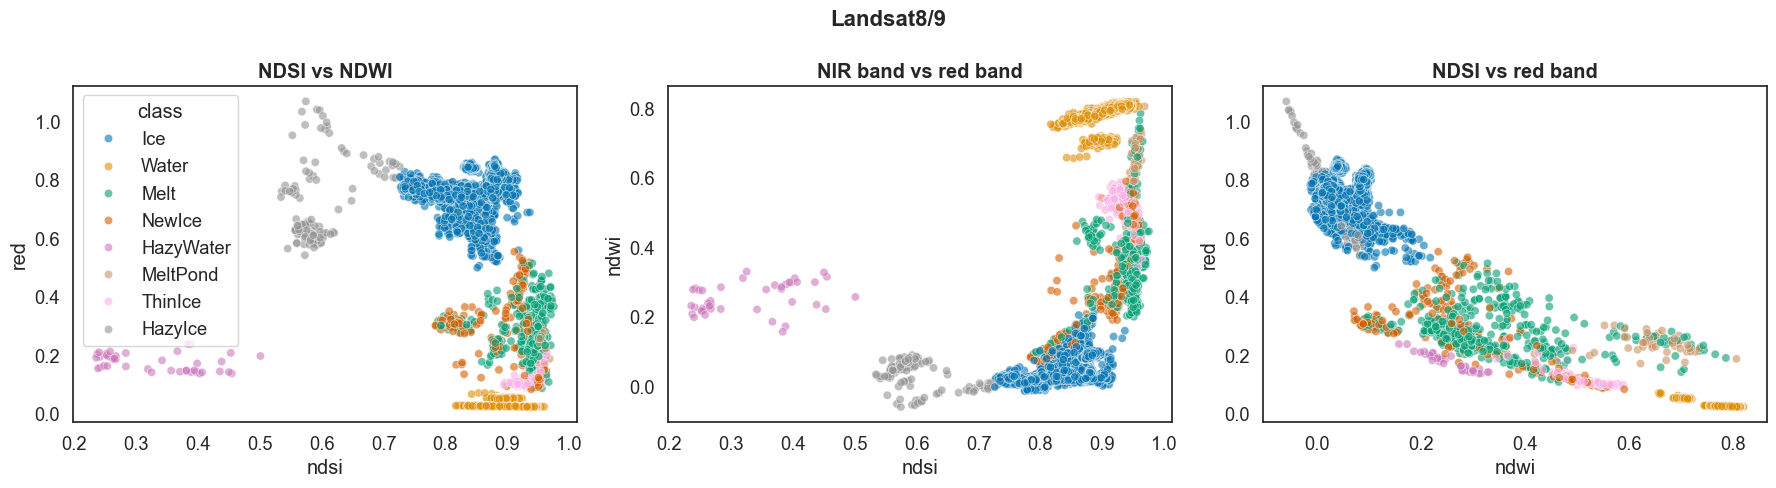

In [163]:
sns.set_style('white')
sampL['ndwi'] = -(sampL['nir'] - sampL['blue']) / (sampL['nir'] + sampL['blue'])
sampL['ndsi'] = -(sampL['swir1'] - sampL['green']) / (sampL['green'] + sampL['swir1'])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# blue vs nir

sns.scatterplot(
    data=sampL, x='ndsi', y='red', 
    hue='class', palette='colorblind', alpha=0.6, 
    ax=axes[0]
)
axes[0].set_title("NDSI vs NDWI", weight="bold")

# nir vs swir1 (hide legend)

sns.scatterplot(
    data=sampL, x='ndsi', y='ndwi', 
    hue='class', palette='colorblind', alpha=0.6, 
    ax=axes[1]
)
axes[1].set_title("NIR band vs red band", weight="bold")
axes[1].get_legend().remove()

# ndsi vs red (hide legend)

sns.scatterplot(
    data=sampL, x='ndwi', y='red', 
    hue='class', palette='colorblind', alpha=0.6, 
    ax=axes[2]
)
axes[2].set_title("NDSI vs red band", weight="bold")
axes[2].get_legend().remove()
plt.suptitle("Landsat8/9", fontsize=16, weight="bold")

# print

plt.tight_layout()
plt.show()

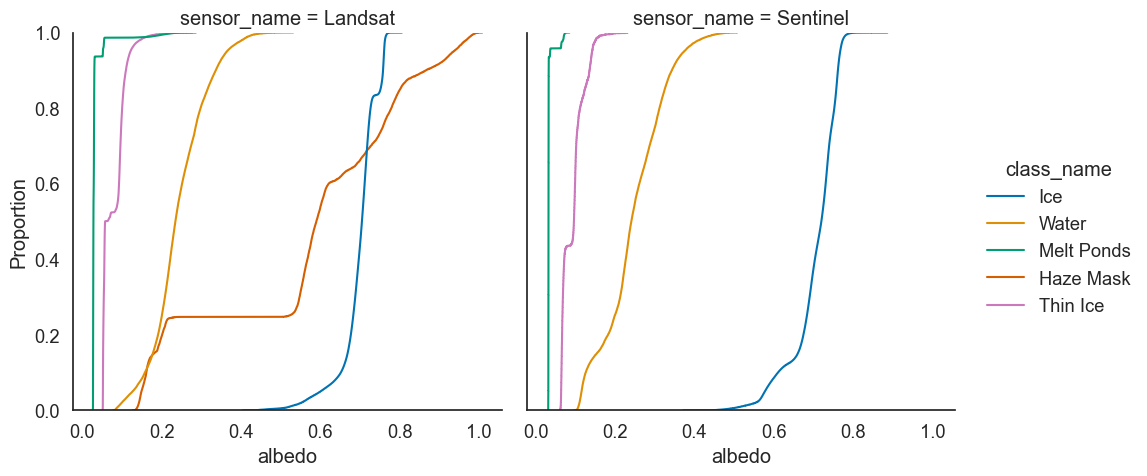

In [166]:
# Empirical Cumulative Distribution Functions

class_map = {
    1: 'Ice',
    2: 'Water',
    3: 'Melt Ponds',
    4: 'Thin Ice',
    5: 'Haze Mask',
    6: 'Haze Mask',
    7: 'Haze Mask'
}

sensor_map = {
    0: 'Landsat',
    1: 'Sentinel'
}
training_data['class_name'] = training_data['class_id'].map(class_map)
training_data['sensor_name'] = training_data['sensor'].map(sensor_map)

training_data['albedo'] = 0.1 * training_data['blue'] + 0.2 * training_data['green'] + 0.3 * training_data['red'] + 0.3 * training_data['nir'] + 0.1 * training_data['swir1']
sns.set_style('white')
sns.displot(training_data, x="albedo", hue="class_name", kind="ecdf", col = 'sensor_name', palette='colorblind')
# plt.tight_layout()

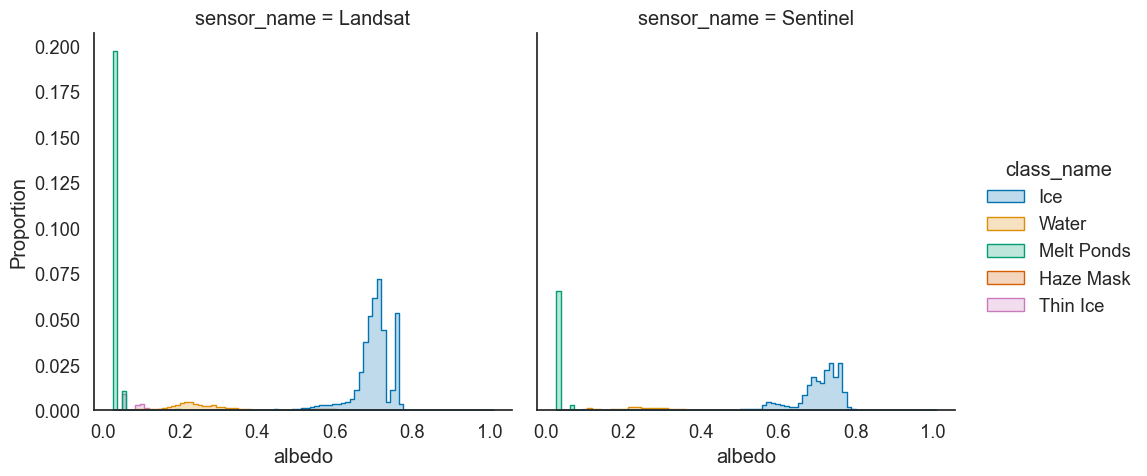

In [172]:
g = sns.displot(
    training_data, 
    x="albedo", 
    hue="class_name", 
    kind="hist",
    element="step",
    stat="proportion",
    fill=True, 
    col="sensor_name", 
    palette="colorblind"
)


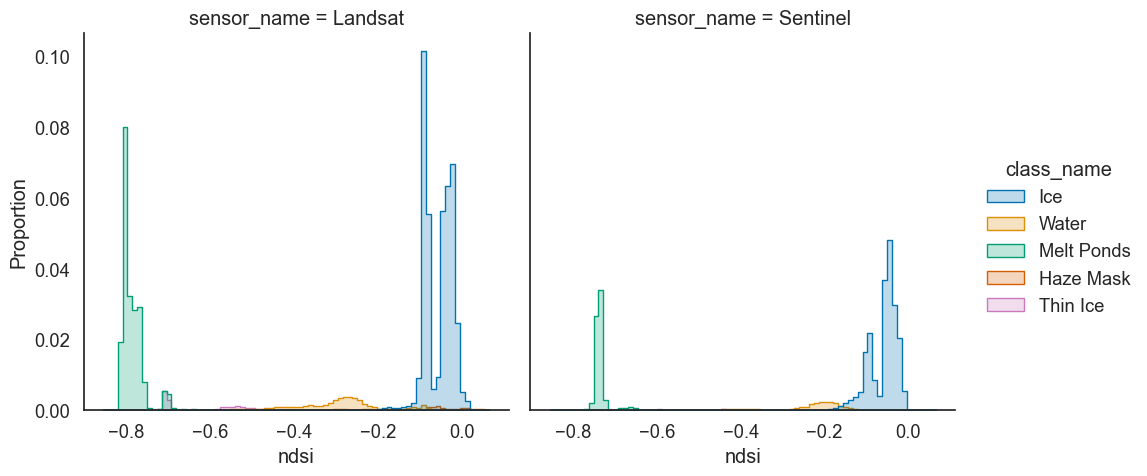

In [175]:
training_data['ndsi'] = (training_data['nir'] - training_data['blue']) / (training_data['blue'] + training_data['nir'])
g = sns.displot(
    training_data, 
    x="ndsi", 
    hue="class_name", 
    kind="hist",
    element="step",
    stat="proportion",
    fill=True, 
    col="sensor_name", 
    palette="colorblind"
)

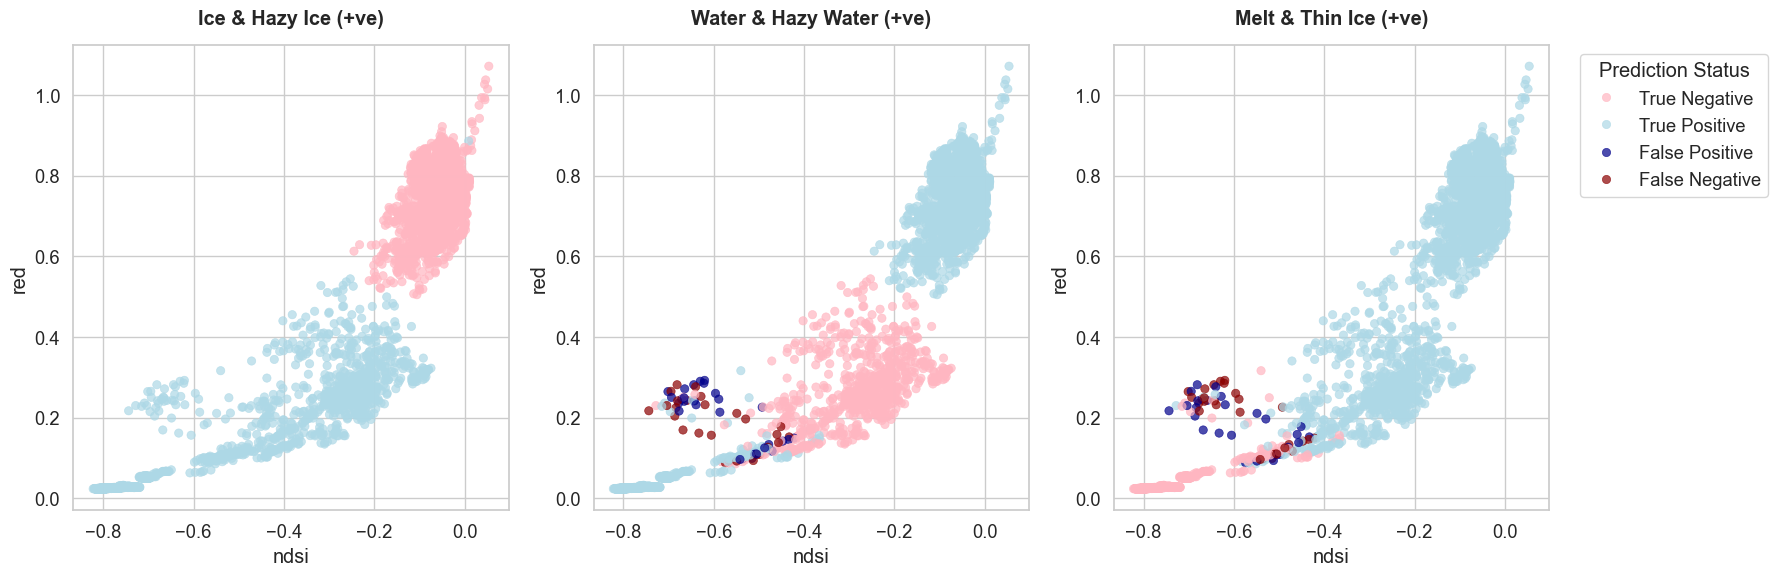

In [148]:
samp = data.sample(10000, random_state=12)

# define your groupings
groups = {
    "Ice & Hazy Ice (+ve)": [1, 6],
    "Water & Hazy Water (+ve)": [2, 5],
    "Melt & Thin Ice (+ve)": [3, 4]
}

# define your custom colors exactly as requested
custom_palette = {
    "True Negative": "lightpink", 
    "True Positive": "lightblue",
    "False Positive": "darkblue",
    "False Negative": "darkred"
}

# specify hue order so the dark errors get plotted ON TOP of the lighter correct points
plot_order = ["True Negative", "True Positive", "False Positive", "False Negative"]

# Set up the figure
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (title, pos_classes) in zip(axes, groups.items()):
    
    # 1. Vectorized logic to identify True/False matches for the current group
    is_true_pos = samp['class_id'].isin(pos_classes)
    is_pred_pos = samp['classification'].isin(pos_classes)
    
    # 2. Assign the 'correctness_class' labels based on those matches
    conditions = [
        is_true_pos & is_pred_pos,   # TP: Expected +ve, Predicted +ve
        ~is_true_pos & ~is_pred_pos, # TN: Expected -ve, Predicted -ve
        ~is_true_pos & is_pred_pos,  # FP: Expected -ve, Predicted +ve
        is_true_pos & ~is_pred_pos   # FN: Expected +ve, Predicted -ve
    ]
    samp['correctness_class'] = np.select(conditions, plot_order, default="Unknown")
    
    # 3. Draw the scatterplot
    sns.scatterplot(
        data=samp, 
        x='ndsi', 
        y='red', 
        hue='correctness_class', 
        palette=custom_palette, 
        hue_order=plot_order, 
        ax=ax, 
        alpha=0.7,
        edgecolor=None # Removes the white rings around dots for a cleaner look
    )
    
    ax.set_title(title, weight="bold", pad=15)
    
    # Clean up legends so we don't have three identical ones
    if ax != axes[-1]:
        ax.get_legend().remove()
    else:
        # Move the final legend outside the plot
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title="Prediction Status", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Counts and Tables

In [144]:
# S2

iceS2 = len(data.loc[data['class_id'] == 1].loc[data['sensor'] == 1])
waterS2 = len(data.loc[data['class_id'] == 2].loc[data['sensor'] == 1])
meltS2 = len(data.loc[data['class_id'] == 3].loc[data['sensor'] == 1])
thinIceS2 = len(data.loc[data['class_id'] == 4].loc[data['sensor'] == 1])
hazyWaterS2 = len(data.loc[data['class_id'] == 5].loc[data['sensor'] == 1])
hazyIceS2 = len(data.loc[data['class_id'] == 6].loc[data['sensor'] == 1])
cloudS2 = len(data.loc[data['class_id'] == 7].loc[data['sensor'] == 1])

# L8/9

iceL89 = len(data.loc[data['class_id'] == 1].loc[data['sensor'] == 0])
waterL89 = len(data.loc[data['class_id'] == 2].loc[data['sensor'] == 0])
meltL89 = len(data.loc[data['class_id'] == 3].loc[data['sensor'] == 0])
thinIceL89 = len(data.loc[data['class_id'] == 4].loc[data['sensor'] == 0])
hazyWaterL89 = len(data.loc[data['class_id'] == 5].loc[data['sensor'] == 0])
hazyIceL89 = len(data.loc[data['class_id'] == 6].loc[data['sensor'] == 0])
cloudL89 = len(data.loc[data['class_id'] == 7].loc[data['sensor'] == 0])

# totals

iceTot = iceS2 + iceL89
waterTot = waterS2 + waterL89
meltTot = meltS2 + meltL89
thinIceTot = thinIceS2 + thinIceL89
hazyWaterTot = hazyWaterS2 + hazyWaterL89
hazyIceTot = hazyIceS2 + hazyIceL89
cloudTot = cloudS2 + cloudL89


lists = [
    [iceL89, iceS2, iceTot],
    [waterL89, waterS2, waterTot],
    [meltL89, meltS2, meltTot],
    [thinIceL89, thinIceS2, thinIceTot],
    [hazyWaterL89, hazyWaterS2, hazyWaterTot],
    [hazyIceL89, hazyIceS2, hazyIceTot],
    [cloudL89, cloudS2, cloudTot],
]


columns = ["Landsat 8/9", "Sentinel 2", "Total"]
index = ['Ice', 'Water', 'Melt Ponds', 'Thin Ice', 'Hazy Water', 'Hazy Ice', 'Cloud']

df = pd.DataFrame(lists, columns=columns, index=index)
df['percentile'] = df['Total'] / df['Total'].sum() * 100
df

,Landsat 8/9,Sentinel 2,Total,percentile
Ice,135493,68135,203628,62.028378
Water,16244,7304,23548,7.173101
Melt Ponds,68927,22506,91433,27.851969
Thin Ice,5789,568,6357,1.936445
Hazy Water,834,0,834,0.254050
Hazy Ice,2423,0,2423,0.738085
Cloud,59,0,59,0.017972


In [151]:
data_full = pd.read_csv('../../local_data/RFTrainingAsset.csv')

# S2

iceS2 = len(data_full.loc[data_full['class_id'] == 1].loc[data_full['sensor'] == 1])
waterS2 = len(data_full.loc[data_full['class_id'] == 2].loc[data_full['sensor'] == 1])
meltS2 = len(data_full.loc[data_full['class_id'] == 3].loc[data_full['sensor'] == 1])
thinIceS2 = len(data_full.loc[data_full['class_id'] == 4].loc[data_full['sensor'] == 1])
hazyWaterS2 = len(data_full.loc[data_full['class_id'] == 5].loc[data_full['sensor'] == 1])
hazyIceS2 = len(data_full.loc[data_full['class_id'] == 6].loc[data_full['sensor'] == 1])
cloudS2 = len(data_full.loc[data_full['class_id'] == 7].loc[data_full['sensor'] == 1])

# L8/9

iceL89 = len(data_full.loc[data_full['class_id'] == 1].loc[data_full['sensor'] == 0])
waterL89 = len(data_full.loc[data_full['class_id'] == 2].loc[data_full['sensor'] == 0])
meltL89 = len(data_full.loc[data_full['class_id'] == 3].loc[data_full['sensor'] == 0])
thinIceL89 = len(data_full.loc[data_full['class_id'] == 4].loc[data_full['sensor'] == 0])
hazyWaterL89 = len(data_full.loc[data_full['class_id'] == 5].loc[data_full['sensor'] == 0])
hazyIceL89 = len(data_full.loc[data_full['class_id'] == 6].loc[data_full['sensor'] == 0])
cloudL89 = len(data_full.loc[data_full['class_id'] == 7].loc[data_full['sensor'] == 0])

# totals

iceTot = iceS2 + iceL89
waterTot = waterS2 + waterL89
meltTot = meltS2 + meltL89
thinIceTot = thinIceS2 + thinIceL89
hazyWaterTot = hazyWaterS2 + hazyWaterL89
hazyIceTot = hazyIceS2 + hazyIceL89
cloudTot = cloudS2 + cloudL89


lists = [
    [iceL89, iceS2, iceTot],
    [waterL89, waterS2, waterTot],
    [meltL89, meltS2, meltTot],
    [thinIceL89, thinIceS2, thinIceTot],
    [hazyWaterL89, hazyWaterS2, hazyWaterTot],
    [hazyIceL89, hazyIceS2, hazyIceTot],
    [cloudL89, cloudS2, cloudTot],
]


columns = ["Landsat 8/9", "Sentinel 2", "Total"]
index = ['Ice', 'Water', 'Melt Ponds', 'Thin Ice', 'Hazy Water', 'Hazy Ice', 'Cloud']

df = pd.DataFrame(lists, columns=columns, index=index)
df['percentile'] = df['Total'] / df['Total'].sum() * 100
df

,Landsat 8/9,Sentinel 2,Total,percentile
Ice,672840,339743,1012583,61.901924
Water,81373,36458,117831,7.203326
Melt Ponds,345057,112100,457157,27.947238
Thin Ice,28677,2984,31661,1.935522
Hazy Water,4091,0,4091,0.250094
Hazy Ice,12194,0,12194,0.745452
Cloud,269,0,269,0.016445
